# Data Downloading and Unzipping

In [1]:
!gdown "https://drive.google.com/uc?id=1_R-ua-F4PsirGc6TTL_DM8i_o9m4PE8v"
!unzip -q "./dataset (2).zip" 

Downloading...
From (original): https://drive.google.com/uc?id=1_R-ua-F4PsirGc6TTL_DM8i_o9m4PE8v
From (redirected): https://drive.google.com/uc?id=1_R-ua-F4PsirGc6TTL_DM8i_o9m4PE8v&confirm=t&uuid=21108b35-697a-41bc-87c0-c0457fa3ae03
To: /kaggle/working/dataset (2).zip
100%|██████████████████████████████████████| 1.13G/1.13G [00:40<00:00, 28.0MB/s]


# Import the essential Libraries

In [2]:

import os  # Operating system interaction
import numpy as np  # Numerical computations
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting
import torch  # Deep learning framework
import torchvision  # Computer vision utilities
import torch.nn as nn  # Neural network building blocks
import torch.optim as optim  # Optimization algorithms
from torch.autograd import Variable  # Automatic differentiation
from torchvision import datasets, transforms, models  # Pre-trained models
from tqdm.notebook import tqdm  # Progress bars
from sklearn.metrics import roc_auc_score, roc_curve, auc  # ROC curve metrics
from sklearn.preprocessing import label_binarize  # Label binarization

# Set matplotlib backend for inline plotting
%matplotlib inline

# Plotting Images from different classes

Class : no substructure 


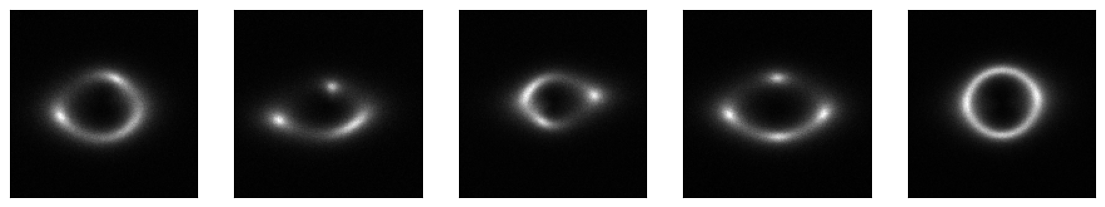

Class : Spherical substructure 


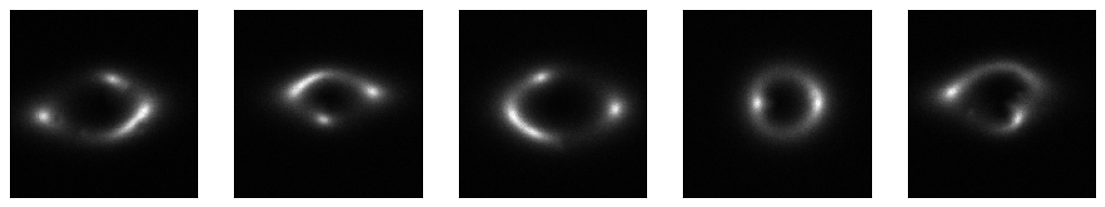

Class : Vortex substructure 


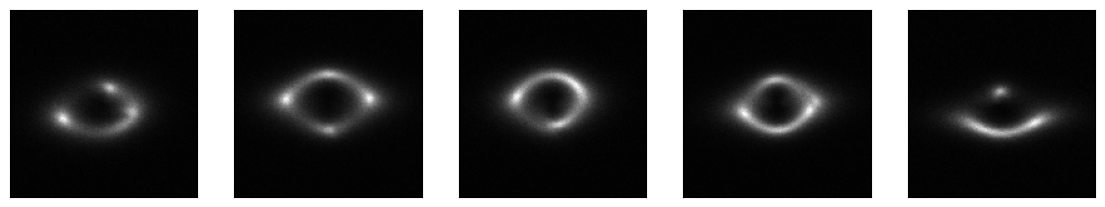

In [3]:
# Defining the input paths for different classes
train_path1 = './dataset/train/no'  # Path for samples with no substructure
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]

train_path2 = './dataset/train/sphere'  # Path for samples with spherical substructure
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]

train_path3 = './dataset/train/vort'  # Path for samples with vortex substructure
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plotting the samples with no substructure
print('Class : no substructure ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the size of the plot
for i, image in enumerate(train_files1[:n], 1):
    ax = plt.subplot(1, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Plotting the samples with spherical substructure
print("Class : Spherical substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files2[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Plotting the samples with vortex substructure
print("Class : Vortex substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files3[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)               # Python random module
    np.random.seed(seed)            # NumPy random generator
    torch.manual_seed(seed)         # PyTorch CPU
    torch.cuda.manual_seed(seed)    # PyTorch GPU
    torch.cuda.manual_seed_all(seed) # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disable auto-optimization for reproducibility

# Set the seed before training
set_seed(42)

def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)


# Creating Pytorch format Dataset and Dataloder

In [5]:
batch_size = 32  # Batch size for training

def load_img(path):

    tensor = torch.from_numpy(np.load(path))
    tensor = tensor.type('torch.FloatTensor')
    return tensor

def transform_img(img):
      transformer = transforms.Compose([
          transforms.Resize((150, 150)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(20),
          transforms.Normalize(mean=[0.5], std=[0.5])
      ])
      img = transformer(img)
      return img

# creating training dataset in pytorch format
train_path = "./dataset/train"
train_data = torchvision.datasets.DatasetFolder(root=train_path, loader=load_img,transform = transform_img, extensions="npy")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# creating validation dataset in pytorch format
val_path = "./dataset/val"
val_data = torchvision.datasets.DatasetFolder(root=val_path, loader=load_img,transform = transform_img, extensions="npy")
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

print("Training Classes: " + str(train_data.class_to_idx))  # Display classes and their indices
print("Validation Classes: " + str(val_data.class_to_idx))

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


In [6]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 150, 150])
torch.Size([32])


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.densenet import DenseNet

class CustomDenseNet(DenseNet):
    def __init__(self, num_classes=3):
        super(CustomDenseNet, self).__init__(growth_rate=32, block_config=(7, 7), num_init_features=64)

        # Modify first convolution layer for grayscale images
        self.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.classifier = nn.Linear(368, num_classes)  # Adjusted output size

# Create model
model = CustomDenseNet(num_classes=3)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [8]:
print(model)

CustomDenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# Number of trainable Parameters

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in your CustomDenseNet model
num_params = count_parameters(model)
print(f"Total Trainable Parameters: {num_params}")


Total Trainable Parameters: 930835


# Training the Model

Epoch 1/50
Train Loss: 1.1011, Train Acc: 0.3397
ROC AUC Score: 0.5078


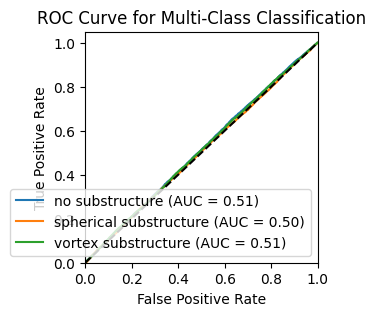

Epoch 2/50
Train Loss: 1.1000, Train Acc: 0.3457
ROC AUC Score: 0.5143


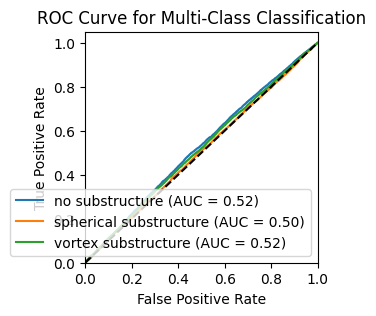

Epoch 3/50
Train Loss: 1.0967, Train Acc: 0.3591
ROC AUC Score: 0.5321


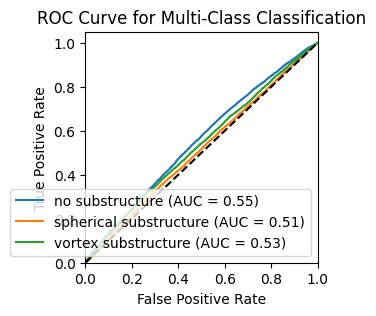

Epoch 4/50
Train Loss: 1.0945, Train Acc: 0.3657
ROC AUC Score: 0.5404


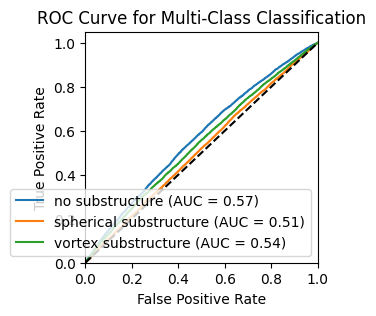

Epoch 5/50
Train Loss: 1.0867, Train Acc: 0.3823
ROC AUC Score: 0.5617


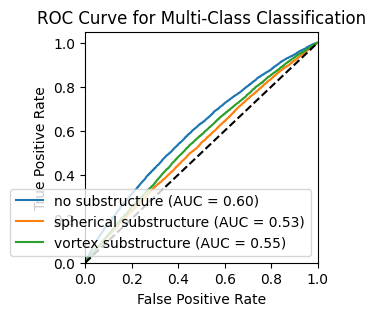

Epoch 6/50
Train Loss: 1.0754, Train Acc: 0.3971
ROC AUC Score: 0.5855


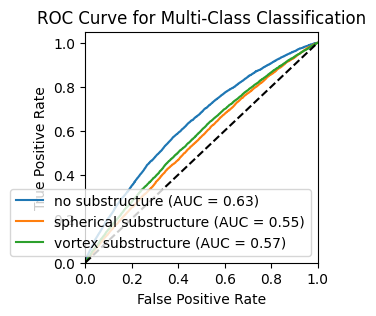

Epoch 7/50
Train Loss: 1.0567, Train Acc: 0.4187
ROC AUC Score: 0.6134


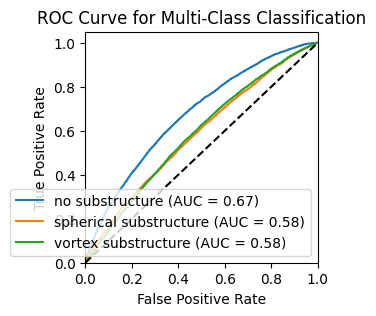

Epoch 8/50
Train Loss: 1.0193, Train Acc: 0.4484
ROC AUC Score: 0.6519


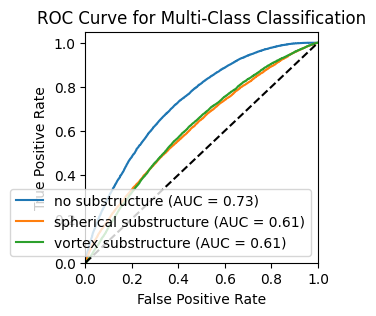

Epoch 9/50
Train Loss: 0.9594, Train Acc: 0.4870
ROC AUC Score: 0.6989


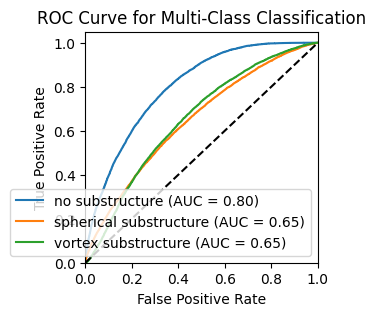

Epoch 10/50
Train Loss: 0.8799, Train Acc: 0.5450
ROC AUC Score: 0.7424


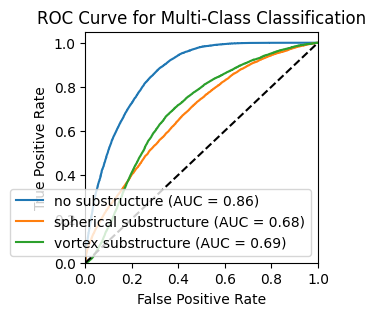

Epoch 11/50
Train Loss: 0.7824, Train Acc: 0.6285
ROC AUC Score: 0.7822


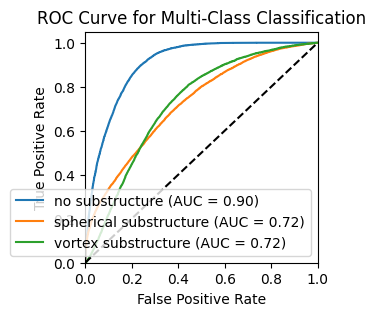

Epoch 12/50
Train Loss: 0.6647, Train Acc: 0.7115
ROC AUC Score: 0.8357


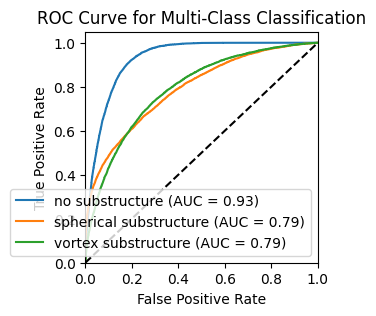

Epoch 13/50
Train Loss: 0.5591, Train Acc: 0.7665
ROC AUC Score: 0.8812


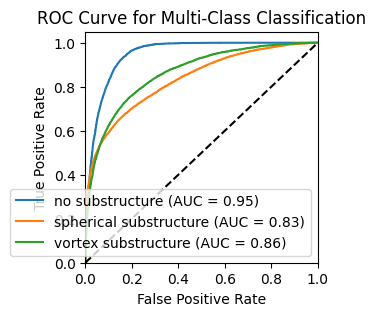

Epoch 14/50
Train Loss: 0.4969, Train Acc: 0.7994
ROC AUC Score: 0.9038


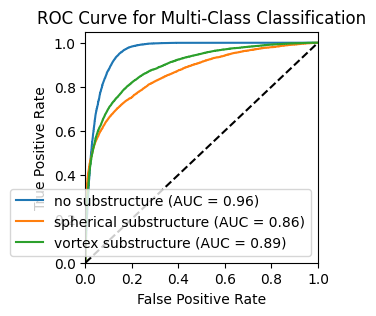

Epoch 15/50
Train Loss: 0.4521, Train Acc: 0.8197
ROC AUC Score: 0.9184


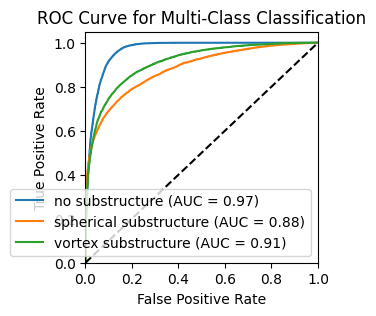

Epoch 16/50
Train Loss: 0.4224, Train Acc: 0.8321
ROC AUC Score: 0.9295


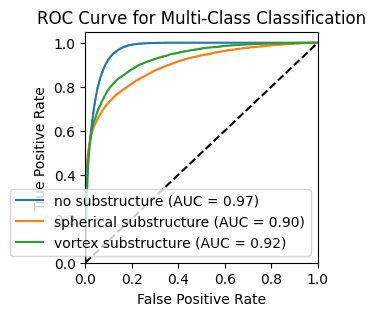

Epoch 17/50
Train Loss: 0.3982, Train Acc: 0.8437
ROC AUC Score: 0.9362


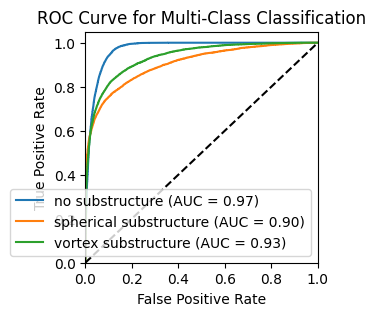

Epoch 18/50
Train Loss: 0.3779, Train Acc: 0.8528
ROC AUC Score: 0.9426


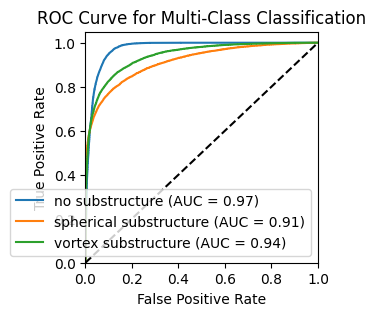

Epoch 19/50
Train Loss: 0.3576, Train Acc: 0.8635
ROC AUC Score: 0.9473


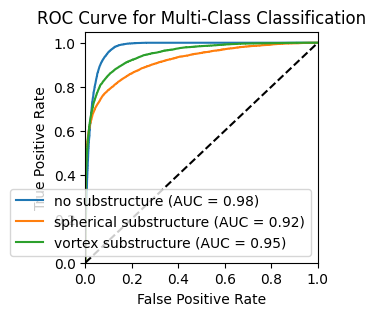

Epoch 20/50
Train Loss: 0.3442, Train Acc: 0.8678
ROC AUC Score: 0.9517


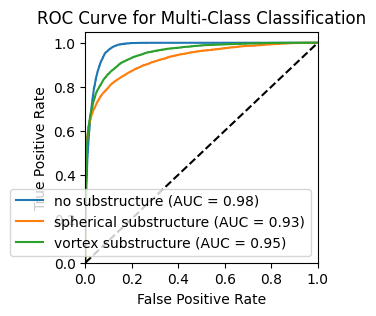

Epoch 21/50
Train Loss: 0.3267, Train Acc: 0.8752
ROC AUC Score: 0.9556


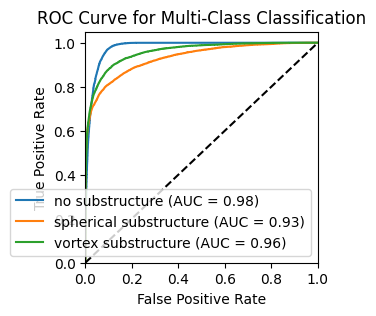

Epoch 22/50
Train Loss: 0.3151, Train Acc: 0.8800
ROC AUC Score: 0.9586


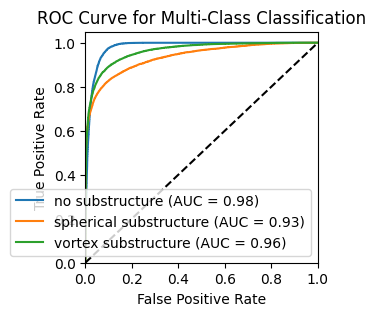

Epoch 23/50
Train Loss: 0.3050, Train Acc: 0.8852
ROC AUC Score: 0.9613


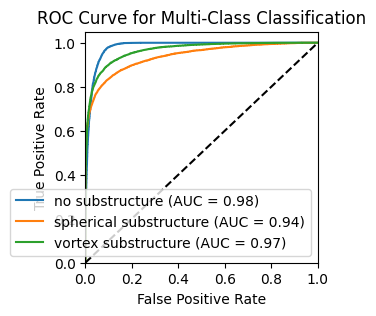

Epoch 24/50
Train Loss: 0.2934, Train Acc: 0.8886
ROC AUC Score: 0.9635


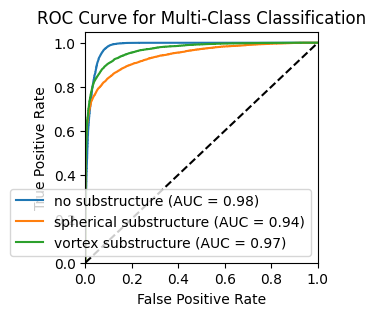

Epoch 25/50
Train Loss: 0.2894, Train Acc: 0.8911
ROC AUC Score: 0.9654


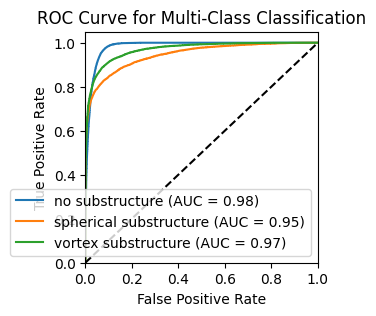

Epoch 26/50
Train Loss: 0.2809, Train Acc: 0.8948
ROC AUC Score: 0.9672


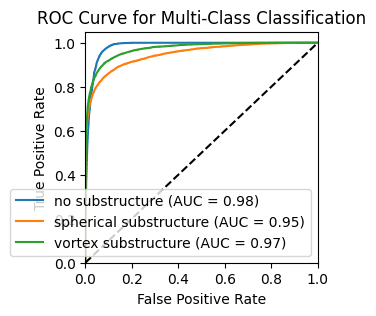

Epoch 27/50
Train Loss: 0.2655, Train Acc: 0.9005
ROC AUC Score: 0.9696


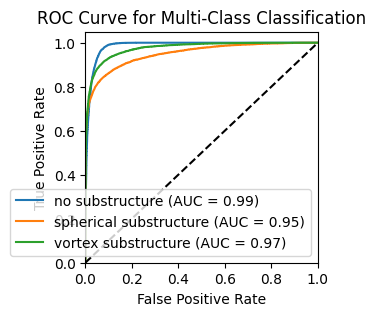

Epoch 28/50
Train Loss: 0.2664, Train Acc: 0.9015
ROC AUC Score: 0.9707


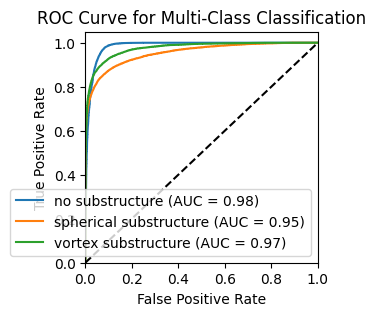

Epoch 29/50
Train Loss: 0.2613, Train Acc: 0.9037
ROC AUC Score: 0.9713


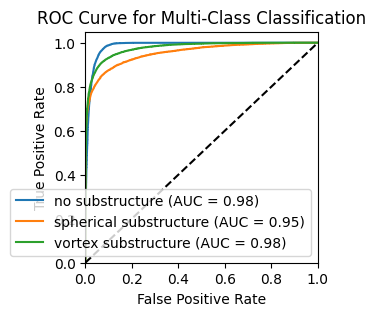

Epoch 30/50
Train Loss: 0.2546, Train Acc: 0.9042
ROC AUC Score: 0.9726


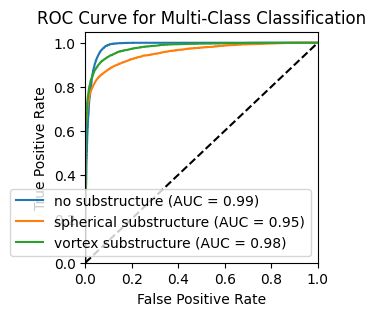

Epoch 31/50
Train Loss: 0.2475, Train Acc: 0.9080
ROC AUC Score: 0.9740


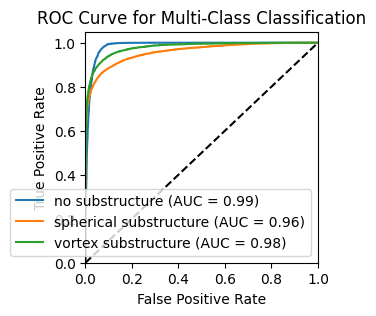

Epoch 32/50
Train Loss: 0.2428, Train Acc: 0.9098
ROC AUC Score: 0.9740


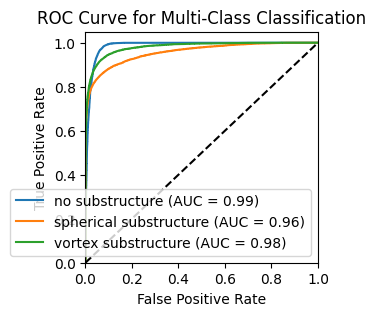

Epoch 33/50
Train Loss: 0.2331, Train Acc: 0.9157
ROC AUC Score: 0.9763


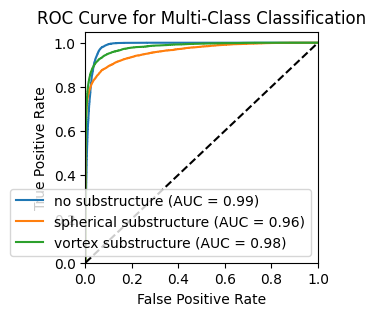

Epoch 34/50
Train Loss: 0.2347, Train Acc: 0.9131
ROC AUC Score: 0.9761


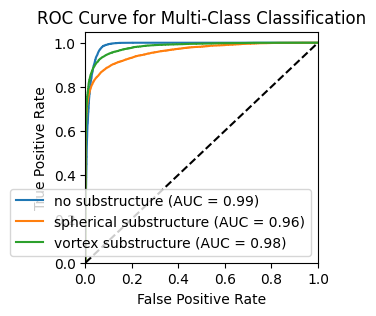

Epoch 35/50
Train Loss: 0.2248, Train Acc: 0.9159
ROC AUC Score: 0.9782


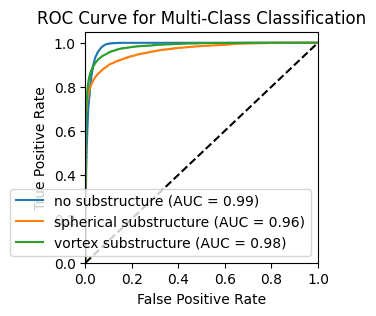

Epoch 36/50
Train Loss: 0.2256, Train Acc: 0.9172
ROC AUC Score: 0.9778


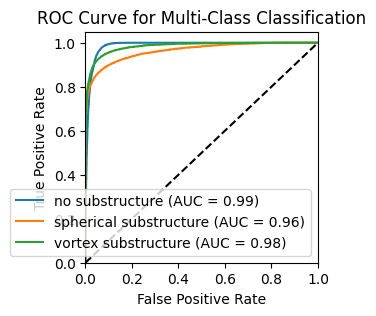

Epoch 37/50
Train Loss: 0.2185, Train Acc: 0.9188
ROC AUC Score: 0.9793


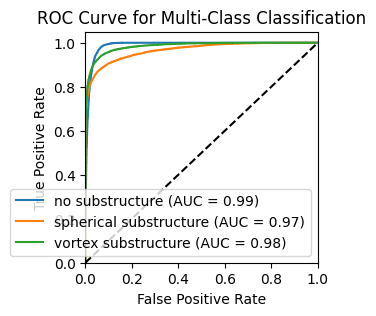

Epoch 38/50
Train Loss: 0.2148, Train Acc: 0.9225
ROC AUC Score: 0.9802


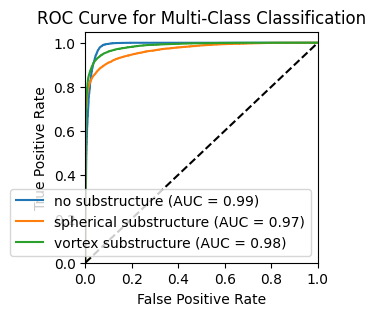

Epoch 39/50
Train Loss: 0.2104, Train Acc: 0.9220
ROC AUC Score: 0.9804


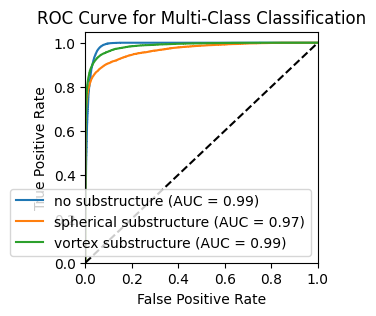

Epoch 40/50
Train Loss: 0.2122, Train Acc: 0.9225
ROC AUC Score: 0.9801


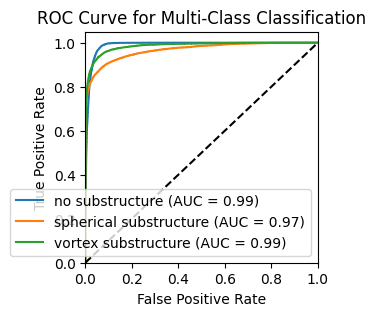

Epoch 41/50
Train Loss: 0.2063, Train Acc: 0.9245
ROC AUC Score: 0.9809


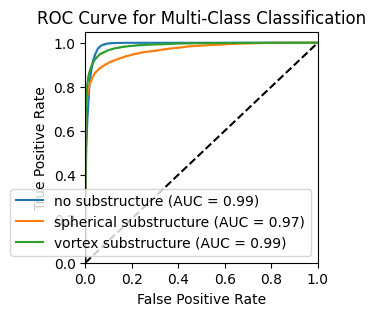

Epoch 42/50
Train Loss: 0.1982, Train Acc: 0.9276
ROC AUC Score: 0.9816


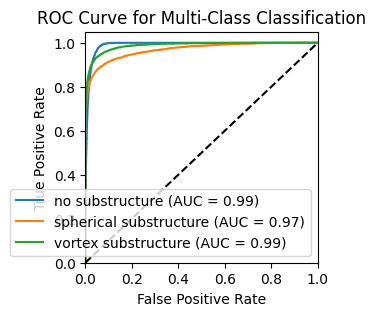

Epoch 43/50
Train Loss: 0.1957, Train Acc: 0.9270
ROC AUC Score: 0.9827


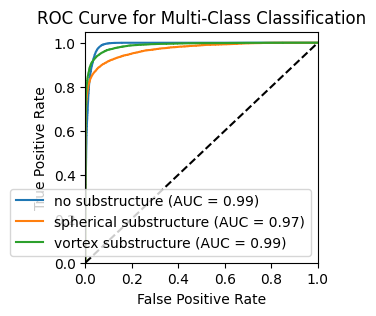

Epoch 44/50
Train Loss: 0.1929, Train Acc: 0.9290
ROC AUC Score: 0.9826


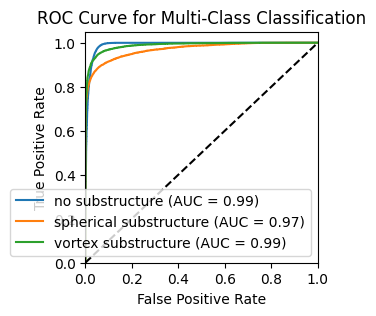

Epoch 45/50
Train Loss: 0.1912, Train Acc: 0.9309
ROC AUC Score: 0.9833


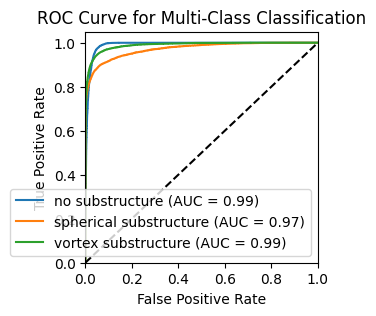

Epoch 46/50
Train Loss: 0.1901, Train Acc: 0.9307
ROC AUC Score: 0.9839


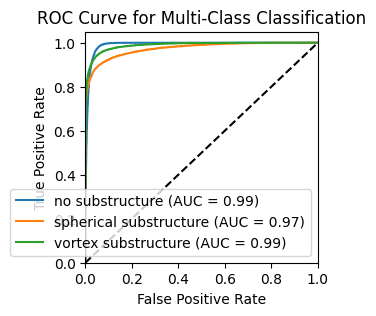

Epoch 47/50
Train Loss: 0.1889, Train Acc: 0.9330
ROC AUC Score: 0.9834


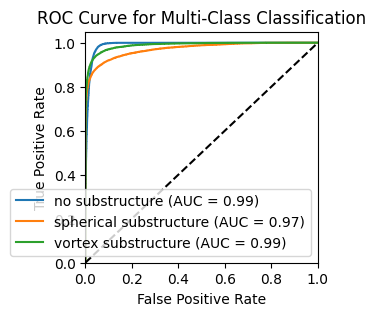

Epoch 48/50
Train Loss: 0.1841, Train Acc: 0.9344
ROC AUC Score: 0.9842


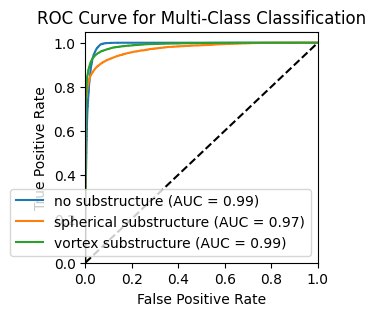

Epoch 49/50
Train Loss: 0.1835, Train Acc: 0.9334
ROC AUC Score: 0.9845


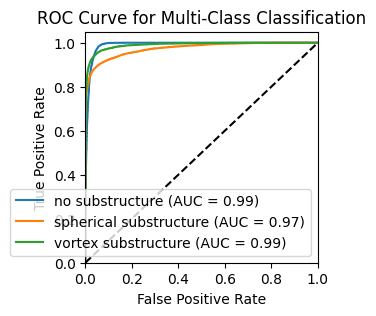

Epoch 50/50
Train Loss: 0.1806, Train Acc: 0.9354
ROC AUC Score: 0.9848


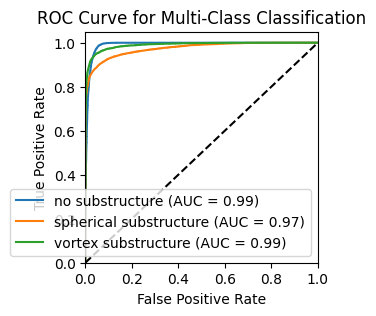

In [10]:

# Training parameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.0005)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()  # Set model to training mode

    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Keep track of total samples

    y_true = []
    y_scores = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum()
        total_samples += labels.size(0)  # Accumulate total number of samples

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        y_true.extend(labels.cpu().numpy())  # Convert labels to NumPy
        y_scores.extend(outputs.detach().cpu().numpy())  # Convert outputs to NumPy

    # Compute average loss and accuracy
    train_loss /= len(train_loader)
    train_acc = correct_predictions / total_samples  # Correct accuracy computation

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Convert lists to NumPy arrays for ROC-AUC calculation
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ROC-AUC computation
    n_classes = len(train_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
    fpr, tpr, roc_auc = {}, {}, []

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
    roc_score = np.mean(roc_auc)
    print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(3,3))
    class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

# Save trained model
torch.save(model.state_dict(), "densnet_model.pth")


# Evaluating the Model

Val Loss: 0.2313, Val Acc: 0.9188
ROC AUC Score: 0.9806


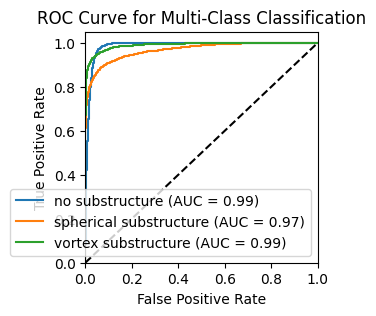

In [11]:
model.eval()  # Set model to evaluation mode

val_loss = 0.0
correct_predictions = 0
total_samples = 0

y_true = []
y_scores = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)  # Accumulate loss

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Compute average loss and accuracy
val_loss /= total_samples
val_acc = correct_predictions / total_samples

print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Convert lists to NumPy arrays for ROC-AUC calculation
y_true = np.array(y_true)
y_scores = np.array(y_scores)

    # ROC-AUC computation
n_classes = len(val_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
fpr, tpr, roc_auc = {}, {}, []

for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
roc_score = np.mean(roc_auc)
print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
plt.figure(figsize=(3,3))
class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()